<a href="https://colab.research.google.com/github/PadamSharma/Sentiment-Analysis-using-BERT/blob/main/sentiment_analysis_using_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# creating folders to ease formation of text dataset
!mkdir global
!mkdir /content/global/train
!mkdir /content/global/dev.gold
!mkdir /content/global/train/0
!mkdir /content/global/train/1
!mkdir /content/global/train/2
!mkdir /content/global/train/3
!mkdir /content/global/train/4
!mkdir /content/global/dev.gold/0
!mkdir /content/global/dev.gold/1
!mkdir /content/global/dev.gold/2
!mkdir /content/global/dev.gold/3
!mkdir /content/global/dev.gold/4

In [ ]:
#training set
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/joy-ratings-0to1.train.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/sadness-ratings-0to1.train.txt

#validation set
!wget http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/anger-ratings-0to1.dev.gold.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/fear-ratings-0to1.dev.gold.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/joy-ratings-0to1.dev.gold.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/sadness-ratings-0to1.dev.gold.txt

In [32]:
emotion_list = ['anger','fear','joy','sadness']
label_dict = {'neutral': '0', 'anger': '1', 'fear': '2', 'joy': '3', 'sadness': '4'}
class_names = {0: 'neutral', 1: 'anger',2: 'fear',3: 'joy',4: 'sadness'}
data_list = ['train','dev.gold']

In [8]:
# creating .txt files in respective folders
count = 0
for data in data_list:
  for emotion in emotion_list:
    File = open('/content/'+emotion+'-ratings-0to1.'+data+'.txt', 'r') 
    lines = File.readlines() 
    for line in lines: 
      line=line.strip()
      l=line.split("\t")
      del(l[0])
      del(l[1])
      if(float(l[1])>(0.35)):
        f=open('/content/global/'+data+'/'+label_dict[emotion]+'/'+str(count)+'.txt',"w")
        f.write(l[0])
        f.close()
      else:
        f=open('/content/global/'+data+'/0/'+str(count)+'.txt',"w")
        f.write(l[0])
        f.close()    
      count+=1

In [ ]:
!pip install -q -U tensorflow-text
!pip install -q -U tf-models-official
!pip install -U tfds-nightly

import os
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [10]:
# importing necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [11]:
# converting text files to tf dataset
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16 * 1
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/global/train',
    batch_size=batch_size,
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/global/dev.gold',
    batch_size=batch_size,
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 3613 files belonging to 5 classes.
Found 347 files belonging to 5 classes.


In [33]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(6):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {class_names[label]}')

Review: b'Bloods boiling'
Label : anger
Review: b"@LickMeLucas ...I'm waiting for you to figure out I'm like... from 0 to 100 real quick with the irritation."
Label : anger
Review: b'i cant stop. i finished - dejected. luckily no one is in the bathroom. so i go to a stall and wait until my pants are dry.'
Label : sadness
Review: b'@OC_Transpo some weeks there are no problems but this week is unbelievable -- are you guys even running regular 12 buses? #awful #solate'
Label : fear
Review: b'#COINCIDENCE??? When you turn on the TV, etc.&amp; listen &amp; watch, the objective is to #CaptureYourMind with #fear &amp; #depression. #FindGODNow!!!'
Label : fear
Review: b'My soul is weary of fighting the battles in this world. #BlackInAmerica #WeAreNotSafe'
Label : sadness


In [13]:
# selecting the required BERT model
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocessing model auto-selected: {tfhub_handle_preprocess}')

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [18]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)


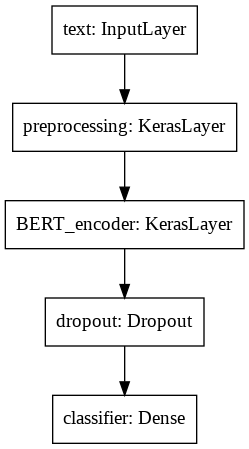

In [19]:
# building and plotting the model
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [20]:
# specifying loss and metrics 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [21]:
epochs = 8
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [22]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [23]:
print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)


Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/8
226/226 [==============================] - 126s 495ms/step - loss: 1.6348 - sparse_categorical_accuracy: 0.2881 - val_loss: 0.8410 - val_sparse_categorical_accuracy: 0.6599
Epoch 2/8
226/226 [==============================] - 111s 490ms/step - loss: 0.8174 - sparse_categorical_accuracy: 0.6853 - val_loss: 0.8261 - val_sparse_categorical_accuracy: 0.6859
Epoch 3/8
226/226 [==============================] - 111s 491ms/step - loss: 0.4961 - sparse_categorical_accuracy: 0.8114 - val_loss: 0.9800 - val_sparse_categorical_accuracy: 0.6801
Epoch 4/8
226/226 [==============================] - 111s 491ms/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9050 - val_loss: 1.1314 - val_sparse_categorical_accuracy: 0.7147
Epoch 5/8
226/226 [==============================] - 111s 490ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.9392 - val_loss: 1.3654 - val_sparse_categorical_accuracy: 0.6888
Ep

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


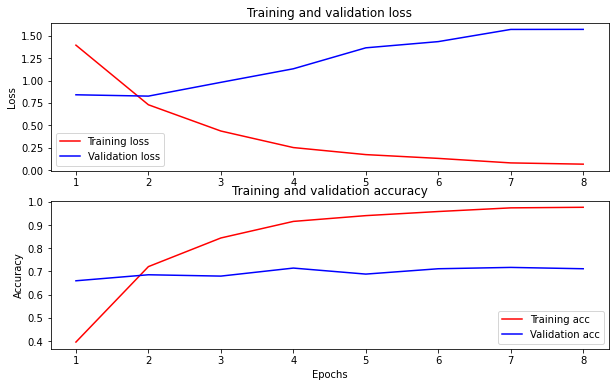

In [24]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [34]:
saved_model_path = 'sentiment_analysis_using_bert'
classifier_model.save(saved_model_path, include_optimizer=False)

In [26]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [27]:
import numpy as np
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} :\n score: {np.argmax(results[i]):.0f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
  'At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes',
	'@CorningFootball  ITS GAME DAY!!!!      T MINUS 14:30  #relentless',
  '#Matthew 25; 1-13\nCould somebody shoot a #video about it?\nIt could be 1 of those #horror videos but in the same time turning many 2 #Christ',
  '@bkero @whispersystems Which really sucks because typing on a mobile device is always horrible and I hate it.',
  'You must be knowing #blithe means (adj.)  Happy, cheerful.',
  'Old saying A #smile shared is one gained for another day @YEGlifer @Scott_McKeen',
  'My 2 teens sons just left in the car to get haircuts. Im praying up a storm that they make it home safely!!',
  'HartRamseys UPLIFT If youre still discouraged it means youre listening to the wrong voices &amp; looking to the wrong source.Look to the LORD!'
]

reloaded_results = (reloaded_model(tf.constant(examples)))
original_results = (classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)


Results from the saved model:
input: At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes :
 score: 1
input: @CorningFootball  ITS GAME DAY!!!!      T MINUS 14:30  #relentless :
 score: 0
input: #Matthew 25; 1-13
Could somebody shoot a #video about it?
It could be 1 of those #horror videos but in the same time turning many 2 #Christ :
 score: 2
input: @bkero @whispersystems Which really sucks because typing on a mobile device is always horrible and I hate it. :
 score: 2
input: You must be knowing #blithe means (adj.)  Happy, cheerful. :
 score: 3
input: Old saying A #smile shared is one gained for another day @YEGlifer @Scott_McKeen :
 score: 3
input: My 2 teens sons just left in the car to get haircuts. Im praying up a storm that they make it home safely!! :
 score: 0
input: HartRamseys UPLIFT If youre still discouraged it means youre listening to the wrong voices &amp; looking to the wrong source.Look to the LORD! :
 score: 4
